In [23]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re, string
import emoji
import nltk


from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim
#transformers
from transformers import BertTokenizerFast
from transformers import BertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel



from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

from tqdm import tqdm, trange

seed=42

## Nvidia data preprocessinп

In [24]:
nvidia_frame = pd.read_csv('/Users/paUpAu/Desktop/nvidia4060_labeled.csv')
nvidia_frame

,#,id,content,author_nickname,author_name,created_at,views,likes,reposts,comments,sentiment
0,1,1962,Good afternoon Gamers Upgrade your Gaming Expe...,@ECB001,ECB TECHNOLOGIES KENYA,22:34.0,1700,39,41,11,B
1,2,1963,"BRAND NEW LAPTOPS Hp Omen 16"" core i7 16gb ram...",@ECB001,ECB TECHNOLOGIES KENYA,32:41.0,703,6,5,0,B
2,3,1964,"4050RtxBrand New Gaming Laptop Hp Omen 16"" co...",@ECB001,ECB TECHNOLOGIES KENYA,57:12.0,1000,44,48,0,B
3,4,1965,Dell G7 16 7630 Gaming 2023Metallic Nightshade...,@stagaone3,TECh WORLD,02:30.0,152,0,2,0,B
4,5,1966,"HP OMEN Gaming Laptop, 13th Gen Intel Core i5-...",@kype_computers,Kype Computers Ltd,34:08.0,1200,5,4,0,B
...,...,...,...,...,...,...,...,...,...,...,...
6662,6663,8611,Studying texture design using #SubstancePainte...,@hallo_w3lt,Víctor Domínguez,58:35.0,200,7,3,0,NaN
6663,6664,8612,Our “Galore v2” comes! Paper: https://Code: ht...,@KyriectionZhang,Zhenyu (Allen) Zhang,10:34.0,19000,90,18,7,NaN
6664,6665,8613,Galax China launches METALTOP Black RTX 4070 T...,@VideoCardz,VideoCardz.com,57:38.0,6400,30,5,0,NaN
6665,6666,8614,The community benchmarking is progressing well...,@EvrFoundation,The Evrmore Foundation,52:45.0,971,43,30,0,NaN


In [25]:
nvidia_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6667 entries, 0 to 6666
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   #                6667 non-null   int64 
 1   id               6667 non-null   int64 
 2   content          6667 non-null   object
 3   author_nickname  6577 non-null   object
 4   author_name      6667 non-null   object
 5   created_at       6667 non-null   object
 6   views            6667 non-null   int64 
 7   likes            6667 non-null   int64 
 8   reposts          6667 non-null   int64 
 9   comments         6667 non-null   int64 
 10  sentiment        209 non-null    object
dtypes: int64(6), object(5)
memory usage: 573.1+ KB


In [26]:
del nvidia_frame['#']

nvidia_frame.drop_duplicates(subset='content',inplace=True)

In [27]:
nvidia_frame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3906 entries, 0 to 6643
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               3906 non-null   int64 
 1   content          3906 non-null   object
 2   author_nickname  3858 non-null   object
 3   author_name      3906 non-null   object
 4   created_at       3906 non-null   object
 5   views            3906 non-null   int64 
 6   likes            3906 non-null   int64 
 7   reposts          3906 non-null   int64 
 8   comments         3906 non-null   int64 
 9   sentiment        194 non-null    object
dtypes: int64(5), object(5)
memory usage: 335.7+ KB


In [28]:
nvidia_frame[['views', 'likes', 'reposts', 'comments']].describe()

,views,likes,reposts,comments
count,3.906000e+03,3906.000000,3906.000000,3906.000000
mean,4.374782e+04,267.605991,91.042499,159.146441
std,2.403493e+05,1570.992233,713.265200,1348.689283
min,0.000000e+00,0.000000,0.000000,0.000000
25%,5.930000e+02,6.000000,3.000000,0.000000
50%,3.200000e+03,23.000000,6.000000,1.000000
75%,1.475000e+04,88.000000,15.000000,7.000000
max,8.100000e+06,42000.000000,27000.000000,40000.000000


/Users/paUpAu/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/paUpAu/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/paUpAu/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/paUpAu/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


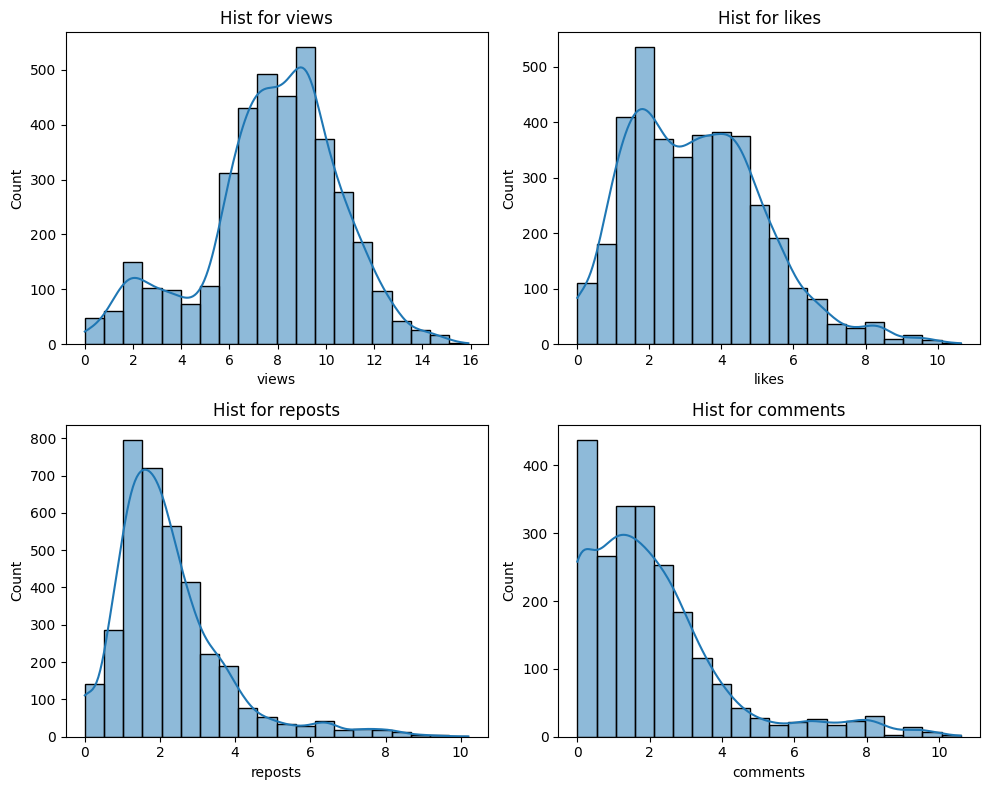

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

sns.histplot(np.log(nvidia_frame['views']), bins=20, ax=axes[0, 0], kde=True).set_title('Hist for views')
sns.histplot(np.log(nvidia_frame['likes']), bins=20, ax=axes[0, 1], kde=True).set_title('Hist for likes')
sns.histplot(np.log(nvidia_frame['reposts']), bins=20, ax=axes[1, 0], kde=True).set_title('Hist for reposts')
sns.histplot(np.log(nvidia_frame['comments']), bins=20, ax=axes[1, 1], kde=True).set_title('Hist for comments')

plt.tight_layout()

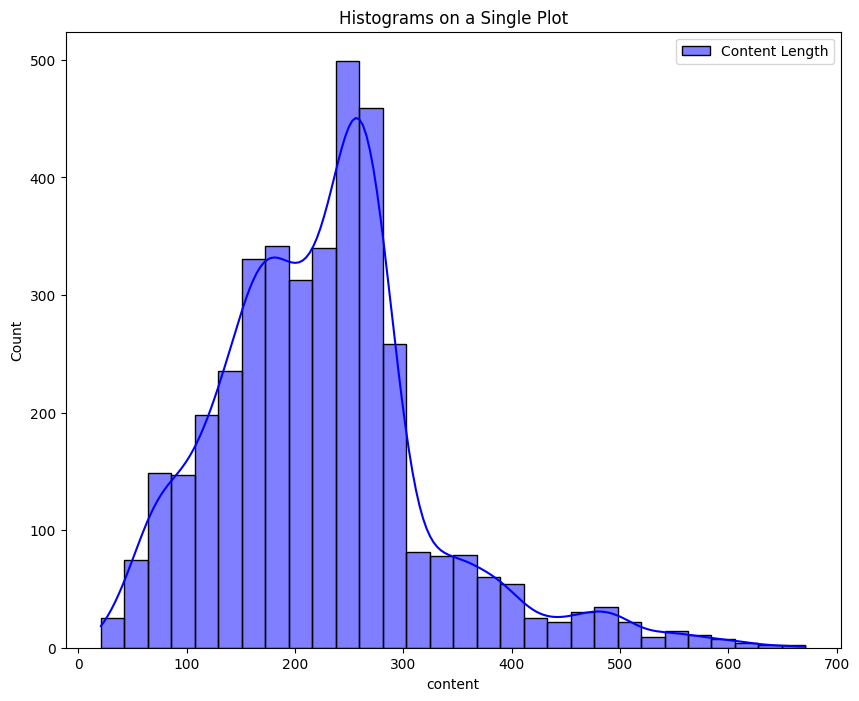

In [30]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.histplot(nvidia_frame['content'].apply(len), bins=30, kde=True, ax=ax, color='blue', label='Content Length')
ax.set_title('Histograms on a Single Plot')
ax.legend()

plt.show()

In [31]:
nvidia_frame['sentiment'].value_counts()

sentiment
B    143
A     35
C     16
Name: count, dtype: int64

In [32]:
df_for_sentiment = nvidia_frame[['content', 'sentiment']]
df_for_sentiment.head()

,content,sentiment
0,Good afternoon Gamers Upgrade your Gaming Expe...,B
1,"BRAND NEW LAPTOPS Hp Omen 16"" core i7 16gb ram...",B
2,"4050RtxBrand New Gaming Laptop Hp Omen 16"" co...",B
3,Dell G7 16 7630 Gaming 2023Metallic Nightshade...,B
4,"HP OMEN Gaming Laptop, 13th Gen Intel Core i5-...",B


In [33]:
def strip_emoji(text):
    RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
    return RE_EMOJI.sub(r'', text)

def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) 
    text = re.sub(r'[^\x00-\x7f]',r'', text) 
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) 
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))
    return new_tweet2

def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

<>:15: SyntaxWarning: invalid escape sequence '\w'
<>:29: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\w'
<>:29: SyntaxWarning: invalid escape sequence '\s'
/var/folders/1q/5d5zy05x55b1dm960102h7740000gp/T/ipykernel_66862/702861350.py:15: SyntaxWarning: invalid escape sequence '\w'
  new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
/var/folders/1q/5d5zy05x55b1dm960102h7740000gp/T/ipykernel_66862/702861350.py:29: SyntaxWarning: invalid escape sequence '\s'
  return re.sub("\s\s+" , " ", text)


In [34]:
texts_new = []
for t in tqdm(df_for_sentiment.content):
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))


df_for_sentiment['content'] = texts_new

100%|██████████| 3906/3906 [00:00<00:00, 60871.48it/s]
/var/folders/1q/5d5zy05x55b1dm960102h7740000gp/T/ipykernel_66862/1456341602.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_for_sentiment['content'] = texts_new


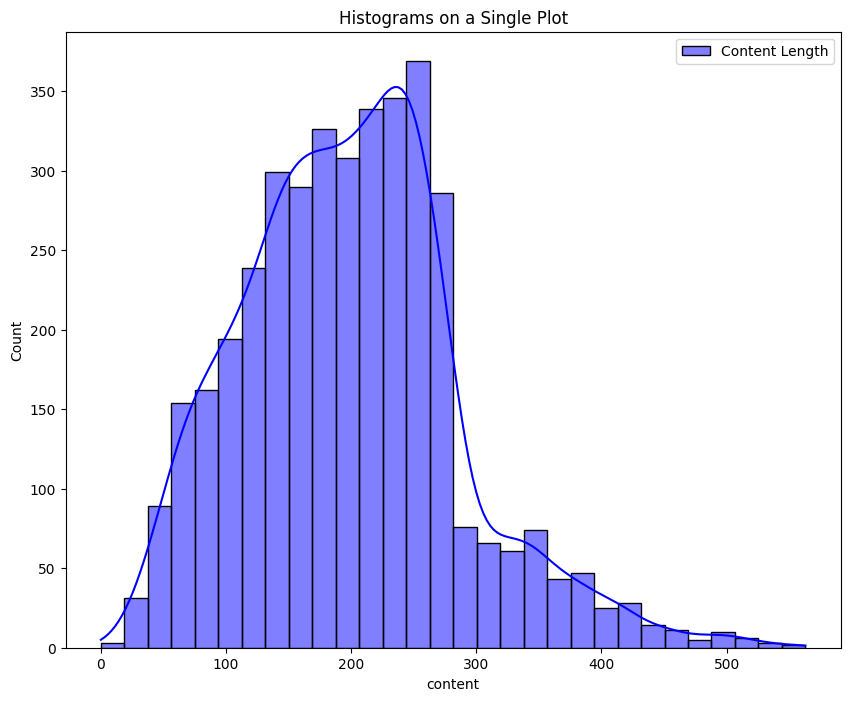

In [35]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.histplot(df_for_sentiment['content'].apply(len), bins=30, kde=True, ax=ax, color='blue', label='Content Length')
ax.set_title('Histograms on a Single Plot')
ax.legend()

plt.show()

In [36]:
df_for_sentiment['content'][1:8].values

array(['brand new laptops hp omen 16 core i7 16gb ram 1tb ssd 6gb graphics rtx nvidia 4050 225000victus by hp gaming core i7 13th gen 156 16gb 1tbssd rtx 3050 6gb nvidia 200000hp spectre 2 in 1 core i7 135 16 gb ram 1tb ssd 13th gen ksh200000hp',
       '4050rtxbrand new gaming laptop hp omen 16 core i7 13th gen storage 16gb ram1tb ssd with 6gb graphics rtx nvidia 4050 price ksh 225000contact 0717040531',
       'dell g7 16 7630 gaming 2023metallic nightshade16 qhd 165hz ips13th generation intel core i713650hx upto490ghz 14cores16gb ddrs ram512gb ssdnvidia geforce rtx 4050 6gb dedicatedbacklit keyboardprice 15500',
       'hp omen gaming laptop 13th gen intel core i513420h 409 cm 161inch fhd 1920 x 1080 microedge antiglare16gb 512 gb ssd nvidia geforce rtx 4050 bowin 11 16wd0770txkes 185000',
       'dell g7 16 7630 gaming 2023metallic nightshade16 qhd 165hz ips13th generation intel r coretm i713650hxupto 490ghz 14cores16gb ddr5 ram512gb ssdnvidia geforce rtx 4050 6gb dedicatedbacklit 

In [37]:
df_for_sentiment = df_for_sentiment.loc[df_for_sentiment['content'] != '']

In [38]:
df_for_sentiment['sentiment'] = df_for_sentiment['sentiment'].map({'C':0,'B':1,'A':2})
df_for_sentiment.head()

,content,sentiment
0,good afternoon gamers upgrade your gaming expe...,1.0
1,brand new laptops hp omen 16 core i7 16gb ram ...,1.0
2,4050rtxbrand new gaming laptop hp omen 16 core...,1.0
3,dell g7 16 7630 gaming 2023metallic nightshade...,1.0
4,hp omen gaming laptop 13th gen intel core i513...,1.0


## Competiitors data preprocessing

In [39]:
competitors_frame = pd.read_csv('/Users/paUpAu/Desktop/competitors_labeled.csv')
competitors_frame.head()

,#,id,content,author_nickname,author_name,created_at,views,likes,reposts,comments,sentiment
0,1,1,"the crypto market competition grows, we need m...",@ec_glob,EntrepreneurCountry Global,09:53.0,0,2,1,0,A
1,2,2,AMD Radeon RX 6800 XT 3DMark Time Spy Extreme ...,@wccftech,Wccftech,18:33.0,38,9,3,0,C
2,3,3,Weird stuff. Asus is blaming AMD guidelines fo...,@BradChacos,Brad Chacos,07:23.0,15,3,6,0,B
3,4,4,"""All-in-all, the Sapphire @Radeon RX Vega 64 N...",@AMD_UK,AMD UK,39:25.0,21,9,2,0,B
4,5,5,"Save power, lower temperatures, and increase b...",@amdradeon,AMD Radeon,00:24.0,98,12,5,0,B


In [40]:
competitors_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   #                2666 non-null   int64 
 1   id               2666 non-null   int64 
 2   content          2666 non-null   object
 3   author_nickname  2651 non-null   object
 4   author_name      2665 non-null   object
 5   created_at       2666 non-null   object
 6   views            2666 non-null   int64 
 7   likes            2666 non-null   int64 
 8   reposts          2666 non-null   int64 
 9   comments         2666 non-null   int64 
 10  sentiment        153 non-null    object
dtypes: int64(6), object(5)
memory usage: 229.2+ KB


In [41]:
del competitors_frame['#']

competitors_frame.drop_duplicates(subset='content',inplace=True)
competitors_frame.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2445 entries, 0 to 2665
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               2445 non-null   int64 
 1   content          2445 non-null   object
 2   author_nickname  2430 non-null   object
 3   author_name      2444 non-null   object
 4   created_at       2445 non-null   object
 5   views            2445 non-null   int64 
 6   likes            2445 non-null   int64 
 7   reposts          2445 non-null   int64 
 8   comments         2445 non-null   int64 
 9   sentiment        130 non-null    object
dtypes: int64(5), object(5)
memory usage: 210.1+ KB


In [42]:
competitors_frame[['views', 'likes', 'reposts', 'comments']].describe()

,views,likes,reposts,comments
count,2.445000e+03,2445.000000,2445.000000,2445.000000
mean,1.001111e+04,60.023722,14.900204,11.437219
std,1.120165e+05,208.183629,101.059801,253.809394
min,0.000000e+00,0.000000,0.000000,0.000000
25%,3.700000e+01,5.000000,2.000000,0.000000
50%,8.210000e+02,17.000000,5.000000,0.000000
75%,4.800000e+03,65.000000,11.000000,2.000000
max,4.800000e+06,7900.000000,4300.000000,10000.000000


/Users/paUpAu/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/paUpAu/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/paUpAu/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/paUpAu/miniconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


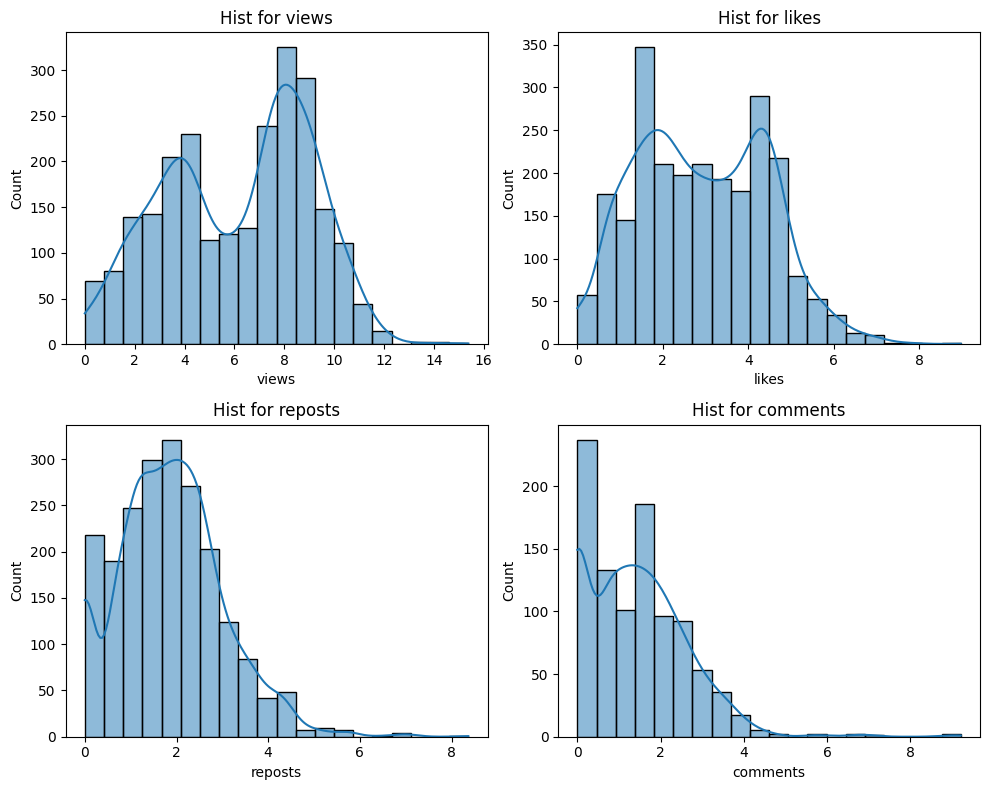

In [43]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

sns.histplot(np.log(competitors_frame['views']), bins=20, ax=axes[0, 0], kde=True).set_title('Hist for views')
sns.histplot(np.log(competitors_frame['likes']), bins=20, ax=axes[0, 1], kde=True).set_title('Hist for likes')
sns.histplot(np.log(competitors_frame['reposts']), bins=20, ax=axes[1, 0], kde=True).set_title('Hist for reposts')
sns.histplot(np.log(competitors_frame['comments']), bins=20, ax=axes[1, 1], kde=True).set_title('Hist for comments')

plt.tight_layout();

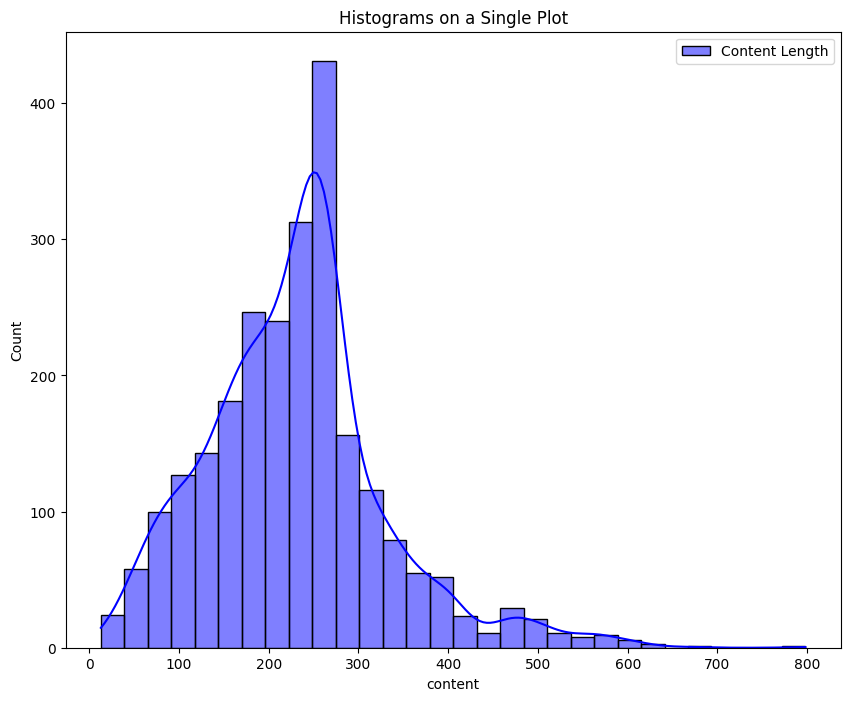

In [44]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.histplot(competitors_frame['content'].apply(len), bins=30, kde=True, ax=ax, color='blue', label='Content Length')
ax.set_title('Histograms on a Single Plot')
ax.legend()

plt.show()

In [45]:
competitors_frame['sentiment'].value_counts()

sentiment
B    82
C    35
A    13
Name: count, dtype: int64

In [46]:
df_compet_for_sentiment = competitors_frame[['content', 'sentiment']]
df_compet_for_sentiment.head()

,content,sentiment
0,"the crypto market competition grows, we need m...",A
1,AMD Radeon RX 6800 XT 3DMark Time Spy Extreme ...,C
2,Weird stuff. Asus is blaming AMD guidelines fo...,B
3,"""All-in-all, the Sapphire @Radeon RX Vega 64 N...",B
4,"Save power, lower temperatures, and increase b...",B


In [47]:
texts_new = []
for t in tqdm(df_compet_for_sentiment.content):
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(strip_emoji(t))))))


df_compet_for_sentiment['content'] = texts_new

100%|██████████| 2445/2445 [00:00<00:00, 48447.26it/s]
/var/folders/1q/5d5zy05x55b1dm960102h7740000gp/T/ipykernel_66862/1106832934.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_compet_for_sentiment['content'] = texts_new


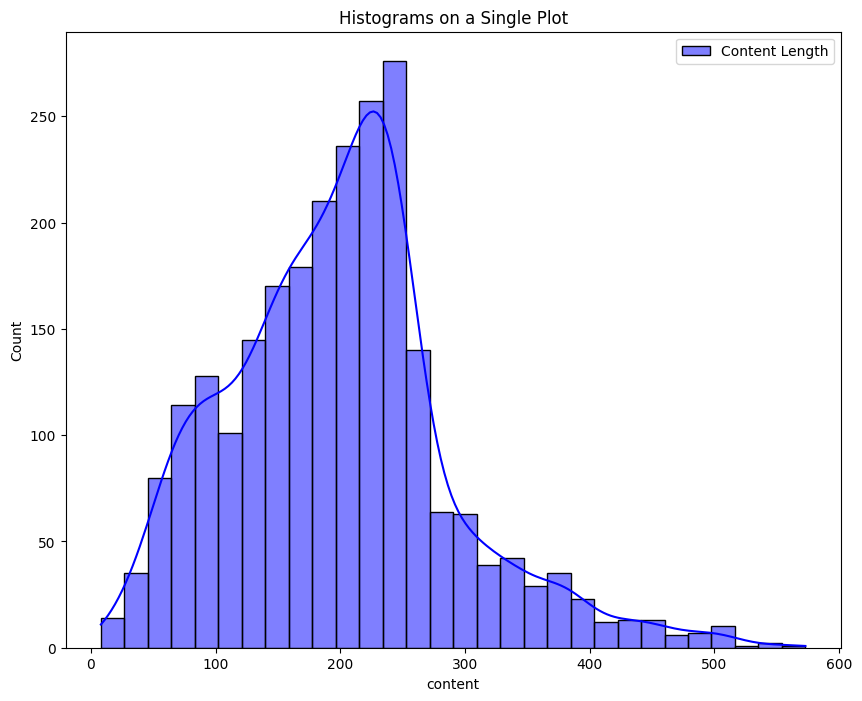

In [48]:
fig, ax = plt.subplots(figsize=(10, 8))

sns.histplot(df_compet_for_sentiment['content'].apply(len), bins=30, kde=True, ax=ax, color='blue', label='Content Length')
ax.set_title('Histograms on a Single Plot')
ax.legend()

plt.show()

In [49]:
df_compet_for_sentiment = df_compet_for_sentiment.loc[df_compet_for_sentiment['content'] != '']

In [28]:
df_compet_for_sentiment['sentiment'] = df_compet_for_sentiment['sentiment'].map({'C':0,'B':1,'A':2})
df_compet_for_sentiment.head()

,content,sentiment
0,the crypto market competition grows we need mo...,2.0
1,amd radeon rx 6800 xt 3dmark time spy extreme ...,0.0
2,weird stuff asus is blaming amd guidelines for...,1.0
3,allinall the sapphire rx vega 64 nitro limited...,1.0
4,save power lower temperatures and increase bat...,1.0


### Data split

In [29]:
df_compet_for_sentiment[df_compet_for_sentiment['sentiment'].notnull()]

,content,sentiment
0,the crypto market competition grows we need mo...,2.0
1,amd radeon rx 6800 xt 3dmark time spy extreme ...,0.0
2,weird stuff asus is blaming amd guidelines for...,1.0
3,allinall the sapphire rx vega 64 nitro limited...,1.0
4,save power lower temperatures and increase bat...,1.0
...,...,...
148,amd radeon rx 7800 xt custom design from asroc...,1.0
149,asrock radeon rx 7800 xt graphics card with 16...,0.0
150,pc upgrade time again help me choose current s...,1.0
151,just indid you hp are trying to diverse gaming...,2.0


In [30]:
df_for_sentiment[df_for_sentiment['sentiment'].notnull()]

,content,sentiment
0,good afternoon gamers upgrade your gaming expe...,1.0
1,brand new laptops hp omen 16 core i7 16gb ram ...,1.0
2,4050rtxbrand new gaming laptop hp omen 16 core...,1.0
3,dell g7 16 7630 gaming 2023metallic nightshade...,1.0
4,hp omen gaming laptop 13th gen intel core i513...,1.0
...,...,...
204,grateful for the rewards from staking with tim...,2.0
205,cooler master haf 5 pro high performance gamin...,1.0
206,buying a fucking phone for 148000just saying y...,1.0
207,acer predator helios neo 16core i7 13th gen wi...,1.0


In [31]:
result = pd.concat([df_for_sentiment, df_compet_for_sentiment], axis=0)
df_labeled = result[result['sentiment'].notnull()]
df_labeled

,content,sentiment
0,good afternoon gamers upgrade your gaming expe...,1.0
1,brand new laptops hp omen 16 core i7 16gb ram ...,1.0
2,4050rtxbrand new gaming laptop hp omen 16 core...,1.0
3,dell g7 16 7630 gaming 2023metallic nightshade...,1.0
4,hp omen gaming laptop 13th gen intel core i513...,1.0
...,...,...
148,amd radeon rx 7800 xt custom design from asroc...,1.0
149,asrock radeon rx 7800 xt graphics card with 16...,0.0
150,pc upgrade time again help me choose current s...,1.0
151,just indid you hp are trying to diverse gaming...,2.0


In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(df_labeled['content'].values, df_labeled['sentiment'].values, test_size=0.1, stratify=df_labeled['sentiment'].values, random_state=seed)

### BERT Sentiment Analysis

In [33]:
from transformers import AutoModel, BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup

from sklearn.metrics import f1_score

In [34]:

MAX_LEN=189
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [35]:
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(X_valid, MAX_LEN)

In [36]:
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = 3,
                                                      output_attentions = False,
                                                      output_hidden_states = False)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [37]:
bert_model.config

BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [38]:
train_inputs = torch.tensor(train_input_ids).to(torch.float32)
train_labels = torch.tensor(y_train).to(torch.float32)
train_masks = torch.tensor(train_attention_masks).to(torch.float32)

validation_inputs = torch.tensor(val_input_ids).to(torch.float32)
validation_labels = torch.tensor(y_valid).to(torch.float32)
validation_masks = torch.tensor(val_attention_masks).to(torch.float32)

In [39]:
dataset_train = TensorDataset(train_inputs, 
                              train_masks,
                              train_labels)

dataset_val = TensorDataset(validation_inputs, 
                             validation_masks, 
                             validation_labels)

In [40]:
batch_size = 4 

dataloader_train = DataLoader(dataset_train,
                              sampler = RandomSampler(dataset_train),
                              batch_size = batch_size)

dataloader_val = DataLoader(dataset_val,
                              sampler = RandomSampler(dataset_val),
                              batch_size = 32) 

In [48]:
dataset_train.tensors

(tensor([[  101.,  1996., 12191.,  ...,     0.,     0.,     0.],
         [  101., 16798.,  2475.,  ...,     0.,     0.,     0.],
         [  101.,  2027.,  2890.,  ...,     0.,     0.,     0.],
         ...,
         [  101.,  2045.,  2015.,  ...,     0.,     0.,     0.],
         [  101., 19387.,  2595.,  ...,     0.,     0.,     0.],
         [  101.,  2403., 11212.,  ...,     0.,     0.,     0.]]),
 tensor([[1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.],
         [1., 1., 1.,  ..., 0., 0., 0.]]),
 tensor([1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 2., 1., 0., 1., 0., 0., 1., 0., 1., 1., 1.,
         1., 2., 1., 1., 1., 1., 2., 1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1.,
         1., 2., 1., 1., 0., 2., 1., 1., 1., 2., 0., 1., 1., 1., 1., 2., 1., 1.,
        

In [41]:
epochs = 6

optimizer = AdamW(bert_model.parameters(),
                 lr = 1e-5,
                 eps = 1e-8)
scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps = len(dataloader_train)*epochs)

/Users/paUpAu/miniconda3/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [42]:
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average = 'weighted')

In [43]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in range(3).items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [44]:
device = "cuda   "
bert_model.to(device)
print(device)

mps


In [45]:
def evaluate(dataloader_val):

    #evaluation mode disables the dropout layer 
    bert_model.eval()
    
    #tracking variables
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in tqdm(dataloader_val):
        
        #load into GPU
        batch = tuple(b.to(device) for b in batch)
        
        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():        
            outputs = bert_model(**inputs)
        
        #compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        #compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    #compute average loss
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

#### Train model

In [46]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [ ]:
for epoch in tqdm(range(1, epochs+1)):

    #set bert_model in train mode
    bert_model.train()

    #tracking variable
    loss_train_total = 0
    
    #set up progress bar
    progress_bar = tqdm(dataloader_train, 
                        desc='Epoch {:1d}'.format(epoch), 
                        leave=False, 
                        disable=False)
    
    for batch in progress_bar:
        #set gradient to 0
        bert_model.zero_grad()

        #load into GPU
        batch = tuple(b.to(device) for b in batch)

        #define inputs
        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2]}
        
        outputs = bert_model(**inputs)
        loss = outputs[0] #output.loss
        loss_train_total +=loss.item()

        #backward pass to get gradients
        loss.backward()
        
        #clip the norm of the gradients to 1.0 to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(bert_model.parameters(), 1.0)
        
        #update optimizer
        optimizer.step()

        #update scheduler
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})     
    
    tqdm.write('\nEpoch {epoch}')
    
    #print training result
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    #evaluate
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    #f1 score
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')

In [50]:
bert_model = torch.load('/Users/paUpAu/Downloads/bert_model.pth', map_location=torch.device('cpu'))

### Prediction

In [53]:
df_unlabeled = result[result['sentiment'].isnull()]
df_unlabeled

,content,sentiment
209,our dual rtx 4060 ti ssd graphicscard just bag...,NaN
210,how low does the rtx 4060 need to go before yo...,NaN
211,heavy duty laptops1st frame hp omen 16core i9 ...,NaN
212,not only sakura check out the latest yeston ga...,NaN
213,nvidias geforce rtx 4060 price drops to 279 ge...,NaN
...,...,...
2659,amd radeon rx 7900 gre coming to north america...,NaN
2662,ready for liftoff explore the vast universe of...,NaN
2663,hp zbook 14u g6intel core i58th gen16gb ram 25...,NaN
2664,amd fsr 3 is now available in sons of the fore...,NaN


In [54]:
max_length = 150
texts = df_unlabeled['content'].tolist()
encoded_texts = tokenizer.batch_encode_plus(
    texts,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=max_length,
    return_tensors='pt'
)

input_ids = encoded_texts['input_ids']
attention_masks = encoded_texts['attention_mask']

bert_model.eval()
with torch.no_grad():
    outputs = bert_model(input_ids, attention_mask=attention_masks)
    logits = outputs.logits

probs = torch.nn.functional.softmax(logits, dim=1)
predictions = torch.argmax(probs, dim=1).numpy()

df_unlabeled['sentiment'] = predictions

df_unlabeled.to_csv('predicted_sentiments.csv', index=False)

print("Predictions saved to predicted_sentiments.csv")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/paUpAu/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


## Validation of numerical numbers in the dataset

In [26]:
nvidia_frame[(nvidia_frame['views'] < nvidia_frame['likes']) | (nvidia_frame['views'] < nvidia_frame['reposts']) | \
             (nvidia_frame['views'] < nvidia_frame['comments'])]

,id,content,author_nickname,author_name,created_at,views,likes,reposts,comments
1042,2989,"RTX 4070 Ti seems make sense, but really?I thi...",@harukaze5719,포시포시,2022-10-14 16:55:14.000000,44,4,3,4070
2696,4632,"Us used Msi GS65 Stealth 9SGPrice: 750,000 nai...",@dolftech_ng,LAPTOPS AND PHONES PLUG!!!!,2022-12-09 11:44:21.000000,4,6,0,0
2699,4635,"Us used Asus TUF Dash F15 Price: 600,000 naira...",@dolftech_ng,LAPTOPS AND PHONES PLUG!!!!,2022-12-01 08:52:05.000000,7,11,2,0
2700,4636,Us used Asus Zephyrus G14 GA4011V gaming lapt...,@dolftech_ng,LAPTOPS AND PHONES PLUG!!!!,2022-11-14 08:53:34.000000,7,9,1,0
2702,4638,"Hp Omen 17 gaming laptopPrice: 650,000 nairaSp...",@dolftech_ng,LAPTOPS AND PHONES PLUG!!!!,2022-11-15 07:14:00.000000,5,8,0,0
...,...,...,...,...,...,...,...,...,...
5929,7876,RUMOR: NVIDIA RTX 3090 Performance Slides Leak...,@Sunnyday_dog,さにーちゃん,2020-08-31 12:44:04.000000,0,2,0,0
5933,7880,Rendering power for every industry: ThinkPad L...,@LinuxCertified,LinuxCertified,2020-09-14 17:54:13.000000,2,8,0,0
5941,7888,Nvidia RTX series will have tensor cores enabl...,@tomordonez,Tom Ordonez,2018-08-30 07:10:16.000000,1,2,0,0
6211,8157,.@GIGABYTEUSA confirms both GeForce RTX 4070 T...,@TweakTown,TweakTown,2022-11-29 05:35:03.000000,1,4,0,0
